In [1]:
import tensorflow as tf
import numpy as np
from modules import *
import time

/home/godming/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path='poetry.txt'
#载入和预处理数据
from data_batches import get_data,get_batches
data=get_data(data_path)
encoder_input_texts_int=data[0]
decoder_input_texts_int=data[1]
decoder_target_texts_int=data[2]
token_index=data[3]
int_str=data[4]
num_tokens=len(int_str)

Number of samples: 34160
Number of unique tokens: 6241
Max sequence length for inputs: 26
Max sequence length for outputs: 82


In [3]:
#超参数
batch_size=32
epochs=100
embedding_size=200
decoder_pad_int=token_index[' ']
encoder_pad_int=token_index[' ']
learning_rate=0.001

In [4]:
encoder_data=tf.placeholder(tf.int32,[None,None],name='encoder_data')
decoder_data=tf.placeholder(tf.int32,[None,None],name='decoder_data')
target_data=tf.placeholder(tf.int32,[None,None],name='target_data')
target_weights=tf.placeholder(tf.float32,[None,None],name='target_weights')

In [5]:
#Embedding
embeddings=tf.Variable(tf.random_uniform([num_tokens,embedding_size],-1.0,1.0))
encoder_embed=tf.nn.embedding_lookup(embeddings,encoder_data,name='Encoder_Embedding')
encoder_embed=PositionEmbedding(encoder_embed,name='Encoder_Position')
decoder_embed=tf.nn.embedding_lookup(embeddings,decoder_data,name='Decoder_Embedding')
decoder_embed=PositionEmbedding(decoder_embed,name='Decoder_Position')

In [6]:
with tf.variable_scope('Encoder'):
    en_M_A1,en_Atten1=Multihead_Attention(encoder_embed,encoder_embed,units=embedding_size,heads=10,name='Multihead_Attention1')
    en_fc1=feedforward(en_M_A1,units=[4*embedding_size,embedding_size],name='feed_forward1')
    en_M_A2,en_Atten2=Multihead_Attention(en_fc1,en_fc1,units=embedding_size,heads=10,name='Multihead_Attention2')
    en_fc2=feedforward(en_M_A2,units=[4*embedding_size,embedding_size],name='feed_forward2')

In [7]:
with tf.variable_scope('Decoder'):
    de_M_A1,de_Atten1=Multihead_Attention(decoder_embed,decoder_embed,units=embedding_size,heads=10,Mask=True,name='Multihead_Attention1')
    de_M_A2,de_Atten2=Multihead_Attention(de_M_A1,en_fc2,units=embedding_size,heads=10,name='Multihead_Attention2')
    de_fc1=feedforward(de_M_A2,units=[4*embedding_size,embedding_size],name='feed_forward1')
    de_M_A3,de_Atten3=Multihead_Attention(de_fc1,de_fc1,units=embedding_size,heads=10,Mask=True,name='Multihead_Attention3')
    de_M_A4,de_Atten4=Multihead_Attention(de_M_A3,en_fc2,units=embedding_size,heads=10,name='Multihead_Attention4')
    de_fc2=feedforward(de_M_A4,units=[4*embedding_size,embedding_size],name='feed_forward2')

In [8]:
logits=tf.layers.dense(de_fc1,units=num_tokens,name='logits')
outputs=tf.argmax(tf.nn.softmax(logits),axis=-1)

In [9]:
temp=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target_data,logits=logits)
cost=tf.reduce_sum(temp*target_weights)/batch_size

In [10]:
train_op=tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [11]:
saver = tf.train.Saver()
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)
train_writer=tf.summary.FileWriter('log',sess.graph)
train_writer.add_graph(sess.graph)

In [12]:
saver.restore(sess,'./save_real/model.ckpt')

In [38]:
for epoch in range(epochs):
    total_loss=0
    start=time.time()
    for batch in get_batches(batch_size,encoder_input_texts_int,decoder_input_texts_int,
                                decoder_target_texts_int,decoder_pad_int, encoder_pad_int):
        feed_dict={encoder_data:batch[0],decoder_data:batch[1],
                      target_data:batch[2],target_weights:batch[3]}
        loss,_=sess.run([cost,train_op],feed_dict=feed_dict)
        total_loss=total_loss+loss
    saver.save(sess,"./save_real/model.ckpt")
    print("epoch:%3d,time:%5.2f,loss:%6.5f"%(epoch,time.time()-start,total_loss))

epoch:  0,time:242.17,loss:226138.08629
epoch:  1,time:219.88,loss:225054.71521
epoch:  2,time:207.59,loss:224088.20344
epoch:  3,time:230.17,loss:223369.58104
epoch:  4,time:233.67,loss:222496.00068
epoch:  5,time:207.57,loss:221617.36115
epoch:  6,time:207.67,loss:220924.58041
epoch:  7,time:207.43,loss:220261.46286
epoch:  8,time:207.45,loss:219747.60975
epoch:  9,time:207.60,loss:219334.11874
epoch: 10,time:207.44,loss:219082.29968
epoch: 11,time:207.67,loss:218738.18179
epoch: 12,time:207.42,loss:218367.66702
epoch: 13,time:207.64,loss:218032.54709
epoch: 14,time:207.59,loss:217707.83445
epoch: 15,time:207.43,loss:217314.49365
epoch: 16,time:207.66,loss:216895.07570
epoch: 17,time:207.56,loss:216550.29222
epoch: 18,time:207.61,loss:216296.09287
epoch: 19,time:207.47,loss:216154.98647
epoch: 20,time:207.50,loss:215925.29753
epoch: 21,time:207.63,loss:215742.37219
epoch: 22,time:207.42,loss:215551.32966
epoch: 23,time:207.56,loss:215299.35735
epoch: 24,time:207.52,loss:215112.38104


KeyboardInterrupt: 

In [39]:
en=batch[0]
de=np.zeros_like(batch[1])
de[:,0]=batch[1][:,0]
pred=np.zeros_like(batch[1])

In [40]:
for i in range(batch[1].shape[1]-1):
    pred_,test=sess.run([outputs,de_M_A1],feed_dict={encoder_data:en,decoder_data:de})
    de[:,i+1]=pred_[:,i]
    pred[:,i]=pred_[:,i]
pred_,test2=sess.run([outputs,de_M_A1],feed_dict={encoder_data:en,decoder_data:de})
pred[:,i+1]=pred_[:,i+1]

In [41]:
(test-test2)[:,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
for i in range(pred.shape[0]):
    poem=""
    for j in range(pred.shape[1]):
        poem+=int_str[pred[i][j]]
    print("-------")
    print(poem)

-------
一片东山下，孤舟泛有风。此中无一事，何处有长安。月出山横笛，风吹水落空。何当此相见，此夕在空山。
醉知
-------
山寺僧房宿，山门树色连。山僧无伴院，林鸟有人看。静落僧中寺，寒寒日上楼。此中无一事，何处是何年。
吟诗
-------
南朝有名士，西望见东山。山色千万叠，山光万万重。云霞藏雨霁，水月照江波。知君有知己，知尔独归休。
醉知
-------
南朝有知己，东望见何峰。海上三湘水，江南万里天。山遥晴野色，水阔晚霞光。知君不可见，此去不相思。
去年
-------
闲居闲夜坐，闲卧出家林。野阔无人迹，山寒有鹤声。闲门无处问，醉卧有时来。明日相思苦，闲门对落晖。
醉眠
-------
夜静中山寺，秋深坐石房。秋声闻磬韵，夜色入禅心。静入云山影，寒回月影微。何当此相访，相伴白云闲。

阳
-------
南北山云里，东山独自安。山中无事处，山下有何人。海树松声满，山云雨影微。何当知我辈，相送入天涯。
吟白
-------
一岁寒更早，相逢此夜阑。此时无限恨，何处是无成。醉后醒来醉，愁多病起愁醒。明朝夕醉，不是旧相思。
吟残
-------
春风吹雨声，春尽落花残。不惜红芳草，何妨白玉钗寒露香浓露滴，风动早风吹。莫惜春风起，春寒满树枝。
醉知
-------
一室从清凉，何人知此心。此中无外日，何处有中心。静坐云生雨，寒声月满禅。何当此相访，相伴老僧禅。
任浮
-------
塞北风吹白，沙南风吹起。沙场武战血，沙月照秦人。战马随风急，胡人向月残。无因见说骨，不是武威平。
化龙
-------
山中多野性，独自有闲心。野步寻僧去，山僧入梦归。山寒过晚树，野阔入寒云扉。明月中兴，相思入梦频。
吟诗
-------
天明明明月，万里白云深。露白云生白，风清露滴青。光含玉砌滴，影入金帘露。明日东山下，相思在剡中。
歌何
-------
一片碧云端，一竿青青青。不知人世乱，只是爱公卿。不得一竿者，不知万里行。何当知此行，一片月华清。
歌不
-------
我有一朝，我知无不可期。我知无所得，我谓我襟袖。不知不可见，其奈何为邻。我谓何妨身，何妨是我家。
往来
-------
我有一水头，不知不可过。我有一，不得尔之之光，不如是其人识此中，不得山中得不同来去，其中有月如。
歌不
-------
山中有仙鹤，万古见灵踪。云雨千峰影，风烟万木光。云凝朝露滴，云动

In [43]:
pred=pred_
for i in range(pred.shape[0]):
    poem=""
    for j in range(pred.shape[1]):
        poem+=int_str[pred[i][j]]
    print("-------")
    print(poem)

-------
一片东山下，孤舟泛有风。此中无一事，何处有长安。月出山横笛，风吹水落空。何当此相见，此夕在空山。
醉知
-------
山寺僧房宿，山门树色连。山僧无伴院，林鸟有人看。静落僧中寺，寒寒日上楼。此中无一事，何处是何年。
吟诗
-------
南朝有名士，西望见东山。山色千万叠，山光万万重。云霞藏雨霁，水月照江波。知君有知己，知尔独归休。
醉知
-------
南朝有知己，东望见何峰。海上三湘水，江南万里天。山遥晴野色，水阔晚霞光。知君不可见，此去不相思。
去年
-------
闲居闲夜坐，闲卧出家林。野阔无人迹，山寒有鹤声。闲门无处问，醉卧有时来。明日相思苦，闲门对落晖。
醉眠
-------
夜静中山寺，秋深坐石房。秋声闻磬韵，夜色入禅心。静入云山影，寒回月影微。何当此相访，相伴白云闲。

阳
-------
南北山云里，东山独自安。山中无事处，山下有何人。海树松声满，山云雨影微。何当知我辈，相送入天涯。
吟白
-------
一岁寒更早，相逢此夜阑。此时无限恨，何处是无成。醉后醒来醉，愁多病起愁醒。明朝夕醉，不是旧相思。
吟残
-------
春风吹雨声，春尽落花残。不惜红芳草，何妨白玉钗寒露香浓露滴，风动早风吹。莫惜春风起，春寒满树枝。
醉知
-------
一室从清凉，何人知此心。此中无外日，何处有中心。静坐云生雨，寒声月满禅。何当此相访，相伴老僧禅。
任浮
-------
塞北风吹白，沙南风吹起。沙场武战血，沙月照秦人。战马随风急，胡人向月残。无因见说骨，不是武威平。
化龙
-------
山中多野性，独自有闲心。野步寻僧去，山僧入梦归。山寒过晚树，野阔入寒云扉。明月中兴，相思入梦频。
吟诗
-------
天明明明月，万里白云深。露白云生白，风清露滴青。光含玉砌滴，影入金帘露。明日东山下，相思在剡中。
歌何
-------
一片碧云端，一竿青青青。不知人世乱，只是爱公卿。不得一竿者，不知万里行。何当知此行，一片月华清。
歌不
-------
我有一朝，我知无不可期。我知无所得，我谓我襟袖。不知不可见，其奈何为邻。我谓何妨身，何妨是我家。
往来
-------
我有一水头，不知不可过。我有一，不得尔之之光，不如是其人识此中，不得山中得不同来去，其中有月如。
歌不
-------
山中有仙鹤，万古见灵踪。云雨千峰影，风烟万木光。云凝朝露滴，云动

In [44]:
pred=sess.run(outputs,feed_dict=feed_dict)
for i in range(pred.shape[0]):
    poem=""
    for j in range(pred.shape[1]):
        poem+=int_str[pred[i][j]]
    print("-------")
    print(poem)

-------
一光此夜中，此古共空穷。此时看寒水，满山树影风。月宫迷共醉，水国静同侵。此想东楼上，相应在此公。

不
-------
山叶满朝寺，清僧不寺开。水光无出谷，山老雨飞回。静井寒横草，寒廊画杂苔。何心多无歇，长世不相哀。何
不
-------
南际山中胜，东西得木空。江江归野里，清浪入烟林。野有山山醉，诗无野客看。知知东文钓，应去有何踪。

有
-------
南少知仙乱，春科尚未仙。江谋与无士，诗首是佳人。楚马行岐路，山钟入月离。知书归不守，相看故人同。知
不
-------
闲郎不已白，不未竹朝开。不病不贫宅，开贫似病衣。窗花春客醉，山雨向僧归。自说公山下，相萝满径乡。

有
-------
夜生何此少，相散雪君闲。此世无相磬，客摇落有风。云凝清有际，月雪似山中。此宿同相此，相松此远公。何
不
-------
南衣何少屈，此自几川朝。不此不为业，归官自得耕。云声山处雪，松入洞山平。莫得东人去，相随入者名。

不
-------
一翁岁除夜，病酒不悠然。此白虽年白，花清叶雪天。病醒闲枕上，愁入枕炉香。此下三相此，相朝是别年。

吟
-------
春花寒梅发，人惜在中吹。不艳含初露，香香风满枝。香花人鸟没，吹任野蜂随。今日东公醉，春人更接花，。
歌
-------
一室从何如，相门何此开。此香无自合，松迹夜犹回。静外松松影，窗寒万月中。谁心不外景，谁是是清台。

觉
-------
塞勒金微贵，，汉山万翠华。胡中人起雪，胡前月照沙。夜儿虏角管，胡虏卷锦衣。胡回秦南望，无落草胜家。
有
-------
山中无谁川，春留何五猿。山云生树影，白照入江南。野雨和风落，寒风夜火遥。何朝不药客，一我独何成。

歌
-------
天今秋此夜，今听火寥官明。此是月华，，何应秋色，。无摇空树，，光满白九平。今常满自，，不旧自知情。
有
-------
一涛有不轻，不之之有须。不头不尔去，波处田之食网。不知鱼溪，，自随鱼夕，。秋有钓鱼主，不尔波涛有。
自
-------
我何有新鱼，不个声夫儿。不中生夫，，风里子君。。不从不不得，不有烟相遇。何谢不无穷，不为不足可去。
自
-------
我于野其中，不为天天坞。不我不不水，歌香满我雾。不闲不色水，，不不生采。。不暮回笑，，不间双金轻。
醉
-------
山羡山侯国，不云空万重。云霞随雪绶，云雨自仙题。云声云云子，云教

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
%matplotlib inline

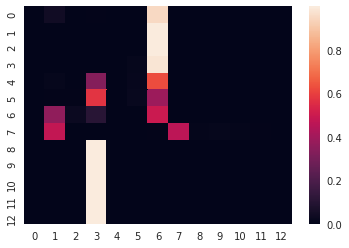

In [37]:
a=sess.run(en_Atten1,feed_dict=feed_dict)
sns.heatmap(a[2,:])